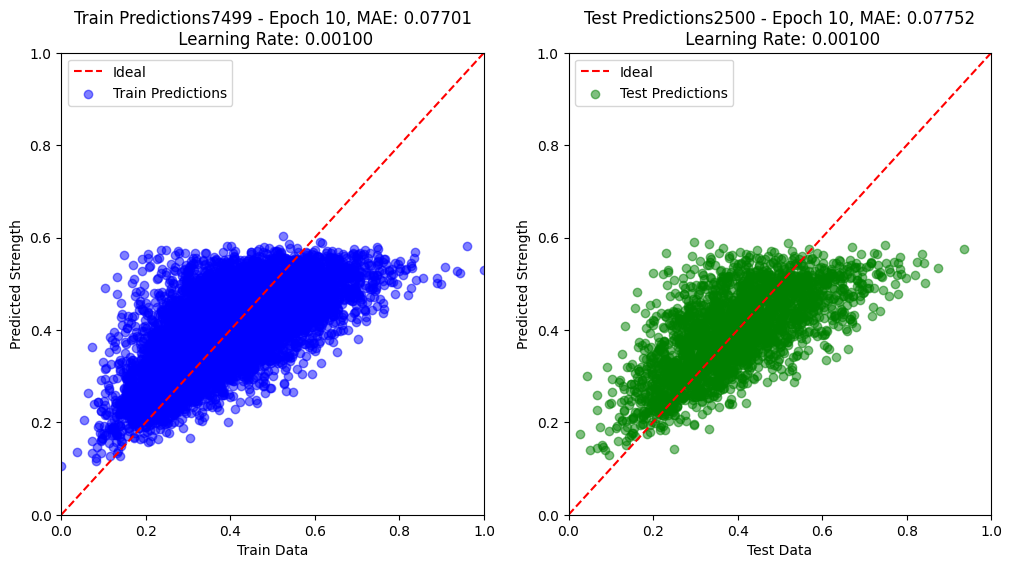

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - De2_loss: 0.2481 - De2_mae: 0.2481 - De_loss: 0.2674 - De_mae: 0.2674 - En_loss: 0.0799 - En_mae: 0.0799 - loss: 0.6064 - val_De2_loss: 0.2461 - val_De2_mae: 0.2461 - val_De_loss: 0.2419 - val_De_mae: 0.2419 - val_En_loss: 0.0730 - val_En_mae: 0.0730 - val_loss: 0.5712 - learning_rate: 0.0010
Epoch 11/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - De2_loss: 0.2475 - De2_mae: 0.2475 - De_loss: 0.2674 - De_mae: 0.2674 - En_loss: 0.0806 - En_mae: 0.0806 - loss: 0.6054 - val_De2_loss: 0.2467 - val_De2_mae: 0.2467 - val_De_loss: 0.2392 - val_De_mae: 0.2392 - val_En_loss: 0.0737 - val_En_mae: 0.0737 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 12/500
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - De2_loss: 0.2477 - De2_mae: 0.2477 - De_loss: 0.2664 - De_mae: 0.2664 - En_loss: 0.0801 - En_mae: 0.0801 - loss: 0.6035 - val_De2_loss: 0.2467 - val_De2_mae: 0.2467 - val_De_loss: 0.2418 - val_De_mae: 0.2418 - val_En_loss: 0.0766 - val_En_mae: 0.0766 - val_los

KeyboardInterrupt: 

In [ ]:
import numpy as np
import json
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Flatten, Reshape,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from CallBacks import PrintLossCallback, EarlyStoppingByTrainMAE, LiveScatterThreeOutputs
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.activations import gelu,elu,tanh
import tensorflow as tf
Iteration=500
lr=0.001
train_size = 0.95
limit=0.04
l2value=0.0005
reduceRate=0.9
modelPath="ANN-5-17.keras"
drop=0.1
batch=125
act="swish"
#act=tanh
init=GlorotUniform()

# Load node data (25 nodes, 3 features: x, y, z)
with open("nodexy.txt", "r") as file:
    NodeOriginal = json.load(file)
NodeOriginal = np.array(NodeOriginal)  # Convert to NumPy array
# Load element data (features for each sample)
with open("thickness.txt", "r") as file:
    element_features = json.load(file)
element_features = np.array(element_features)  # Convert to NumPy array
# Load target values
energy = np.loadtxt("energy_absorbed.txt")
energy = np.array(energy).reshape(-1, 1)  # Ensure correct shape
minValue=np.argmin(energy)
mask1=np.arange((len(energy))) !=minValue
NodeOriginal=NodeOriginal[mask1,:,:]
element_features=element_features[mask1,:]
energy=energy[mask1]
# Extract x, y coordinates
NodeOriginal_x = NodeOriginal[:, :, 0]  # Extract all x-coordinates
NodeOriginal_y = NodeOriginal[:, :, 1]  # Extract all y-coordinates
# Identify and remove edge nodes (x or y = 0 or 30)
_, EdgeNodes = np.where((NodeOriginal_x == 0) | (NodeOriginal_x == 30) | (NodeOriginal_y == 0) | (NodeOriginal_y == 30))
EdgeNodes = np.unique(EdgeNodes)  # Get unique node indices to remove
# Create a mask and filter out edge nodes
mask2 = np.ones(NodeOriginal.shape[1], dtype=bool)
mask2[EdgeNodes] = False
filtered_nodes = NodeOriginal[:, mask2, :]
print(filtered_nodes.shape)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()
element_scaler = MinMaxScaler()
energy_scaler = MinMaxScaler()

nodex = scaler_x.fit_transform(filtered_nodes[ :, :, 0])
nodey = scaler_y.fit_transform(filtered_nodes[ :, :, 1])
NodeFeature=np.stack([nodex,nodey],axis=-1)
print(NodeFeature.shape)
element_features = element_scaler.fit_transform(element_features)
energy = energy_scaler.fit_transform(energy)

# Split data into training and testing sets
X_train_nodes, X_test_nodes, X_train_elements, X_test_elements, y_train, y_test = train_test_split(
    NodeFeature, element_features, energy, test_size=1 - train_size, random_state=42)
print(NodeFeature.shape[1],NodeFeature.shape[2])
# Define CNN model for node features
node_input = Input((NodeFeature.shape[1],NodeFeature.shape[2]), name="Node_Input")
node_branch=Dense(125,activation=act,kernel_initializer=init)(node_input)
node_branch=Dropout(drop)(node_branch)
node_branch=Dense(100,activation=act,kernel_initializer=init)(node_branch)
node_branch=Dropout(drop)(node_branch)
node_branch=Dense(100,activation=act,kernel_initializer=init)(node_branch)
node_branch=Dropout(drop)(node_branch)
node_branch=Dense(80,activation=act,kernel_initializer=init)(node_branch)
node_branch=Dropout(drop)(node_branch)
node_branch=Dense(40,activation=act,kernel_initializer=init,kernel_regularizer=l2(l2value))(node_branch)
node_branch=Dense(30,activation=act,kernel_initializer=init,kernel_regularizer=l2(l2value))(node_branch)
node_branch=Flatten()(node_branch)
# Define ANN model for element features
element_input  = Input((X_train_elements.shape[1],), name="Element_Input")
element_branch = Dense(125, activation=act,kernel_initializer=init)(element_input)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(100, activation=act,kernel_initializer=init)(element_branch)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(100, activation=act,kernel_initializer=init)(element_branch)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(80, activation=act,kernel_initializer=init)(element_branch)
element_branch = Dropout(drop)(element_branch)
element_branch = Dense(40, activation=act,kernel_initializer=init,kernel_regularizer=l2(l2value))(element_branch)
element_branch = Dense(30, activation=act,kernel_initializer=init,kernel_regularizer=l2(l2value))(element_branch)


# Concatenate CNN and ANN features
merged = Concatenate()([node_branch, element_branch])
latentSpace=Dense(60,activation=act,kernel_initializer=init)(merged)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(35,activation=act,kernel_initializer=init)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(15,activation=act,name="Latent",kernel_initializer=init,kernel_regularizer=l2(l2value))(latentSpace)
merged = Dense(4, activation=act,kernel_initializer=init)(latentSpace)
merged = Dense(2, activation=act,kernel_initializer=init)(merged)
encode = Dense(1, activation=act, name="En",kernel_initializer=init)(merged)

decoded = Dense(30, activation=act,kernel_initializer=init)(latentSpace)
decoded = Dropout(drop)(decoded)
decoded = Dense(60, activation=act,kernel_initializer=init)(decoded)
decoded = Dropout(drop)(decoded)
decoded = Dense(60, activation=act,kernel_initializer=init)(decoded)
decoded = Dropout(drop)(decoded)
decoded = Dense((NodeFeature.shape[1]*NodeFeature.shape[2]), activation=act,kernel_initializer=init)(decoded)
decoded = Dropout(drop)(decoded)
decode = Reshape((NodeFeature.shape[1],NodeFeature.shape[2]),name="De")(decoded)

decoded2= Dense(12,kernel_initializer=init, kernel_regularizer=l2(l2value))(latentSpace)
decoded2= Dense(24,kernel_initializer=init)(decoded2)
decoded2 = Dropout(drop)(decoded2)
decoded2= Dense(24,kernel_initializer=init)(decoded2)
decoded2= Dropout(drop)(decoded2)
decoded2= Dense(30,kernel_initializer=init)(decoded2)
decoded2 = Dropout(drop)(decoded2)
decoded2= Dense(36,kernel_initializer=init,name="De2")(decoded2)
def log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true)))
# Create model
if os.path.exists(modelPath):
    print("Loading model")
    model=load_model(modelPath,custom_objects={ "log_cosh_loss": log_cosh_loss})
else:
    print("Creating model")
    model = Model(inputs=[node_input, element_input], outputs=[encode,decode,decoded2])



model.compile(optimizer=Adam(learning_rate=lr), 
              loss={"En": "mae", "De":"mae","De2":"mae"},
              metrics={"En": ["mae"], "De": ["mae"],"De2": ["mae"]})

# Define callbacks for early stopping and learning rate reduction
checkpoint = ModelCheckpoint(modelPath, monitor="val_En_mae", save_best_only=True, mode="min", verbose=0)
reduce_lr = ReduceLROnPlateau(monitor="En_mae", factor=reduceRate, patience=40, min_lr=1e-6, verbose=0)
X_train_nodes = np.array(X_train_nodes, dtype=np.float32)
LossMonitor = PrintLossCallback("En_mae",interval=500)
early_stopping = EarlyStoppingByTrainMAE("En_mae",threshold=limit)
plot=LiveScatterThreeOutputs(X_train_nodes,X_test_nodes, X_train_elements,X_test_elements, y_train, y_test, interval=10)

print(f"Model output shapes: {[o.shape for o in model.outputs]}")
print(f"y_train shape: {y_train.shape}") 
print(f"X_train_nodes shape: {X_train_nodes.shape}")

# Train model
history = model.fit(
    [X_train_nodes, X_train_elements],
    [y_train, X_train_nodes,X_train_elements],
    epochs=Iteration,
    batch_size=batch,
    validation_split=0.05,
    callbacks=[checkpoint,LossMonitor,reduce_lr,plot],
    verbose=1
)


In [74]:
import numpy as np
import json
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Flatten, Reshape,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from CallBacks import PrintLossCallback, EarlyStoppingByTrainMAE, LiveScatterThreeOutputs
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.activations import gelu,elu,tanh
import tensorflow as tf

Iteration=1000
lr=0.001
train_size = 0.95
limit=0.04
l2value=0.0001
reduceRate=0.9
drop=0.05
batch=125
act="swish"
#act=tanh
init=GlorotUniform()
maeValues=[]
rang=45
# Load node data (25 nodes, 3 features: x, y, z)
with open("nodexy.txt", "r") as file:
    NodeOriginal = json.load(file)
NodeOriginal = np.array(NodeOriginal)  # Convert to NumPy array
# Load element data (features for each sample)
with open("thickness.txt", "r") as file:
    element_features = json.load(file)
element_features = np.array(element_features)  # Convert to NumPy array
# Load target values
energy = np.loadtxt("energy_absorbed.txt")
energy = np.array(energy).reshape(-1, 1)  # Ensure correct shape
minValue=np.argmin(energy)
mask1=np.arange((len(energy))) !=minValue
NodeOriginal=NodeOriginal[mask1,:,:]
element_features=element_features[mask1,:]
energy=energy[mask1]
# Extract x, y coordinates
NodeOriginal_x = NodeOriginal[:, :, 0]  # Extract all x-coordinates
NodeOriginal_y = NodeOriginal[:, :, 1]  # Extract all y-coordinates
# Identify and remove edge nodes (x or y = 0 or 30)
_, EdgeNodes = np.where((NodeOriginal_x == 0) | (NodeOriginal_x == 30) | (NodeOriginal_y == 0) | (NodeOriginal_y == 30))
EdgeNodes = np.unique(EdgeNodes)  # Get unique node indices to remove
# Create a mask and filter out edge nodes
mask2 = np.ones(NodeOriginal.shape[1], dtype=bool)
mask2[EdgeNodes] = False
filtered_nodes = NodeOriginal[:, mask2, :]
print(filtered_nodes.shape)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()
element_scaler = MinMaxScaler()
energy_scaler = MinMaxScaler()

nodex = scaler_x.fit_transform(filtered_nodes[ :, :, 0])
nodey = scaler_y.fit_transform(filtered_nodes[ :, :, 1])
NodeFeature=np.stack([nodex,nodey],axis=-1)
print(NodeFeature.shape)
element_features = element_scaler.fit_transform(element_features)
energy = energy_scaler.fit_transform(energy)

# Split data into training and testing sets
X_train_nodes, X_test_nodes, X_train_elements, X_test_elements, y_train, y_test = train_test_split(
    NodeFeature, element_features, energy, test_size=1 - train_size, random_state=42)

for i in range(0,rang):
    modelPath=f"ANN-5-Data-{i}.keras"
    indices=np.random.choice(y_train.shape[0],200*(i+1),replace=False)
    nodeset=X_train_nodes[indices,:,:]
    print(nodeset.shape)
    elementset=X_train_elements[indices,:]
    energyset=y_train[indices]
    # Define CNN model for node features
    node_input = Input((NodeFeature.shape[1],NodeFeature.shape[2]), name="Node_Input")
    node_branch=Dense(125,activation=act,kernel_initializer=init)(node_input)
    node_branch=Dropout(drop)(node_branch)
    node_branch=Dense(100,activation=act,kernel_initializer=init)(node_branch)
    node_branch=Dropout(drop)(node_branch)
    node_branch=Dense(100,activation=act,kernel_initializer=init)(node_branch)
    node_branch=Dropout(drop)(node_branch)
    node_branch=Dense(80,activation=act,kernel_initializer=init)(node_branch)
    node_branch=Dropout(drop)(node_branch)
    node_branch=Dense(40,activation=act,kernel_initializer=init,kernel_regularizer=l2(l2value))(node_branch)
    node_branch=Dense(30,activation=act,kernel_initializer=init,kernel_regularizer=l2(l2value))(node_branch)
    node_branch=Flatten()(node_branch)
    # Define ANN model for element features
    element_input  = Input((X_train_elements.shape[1],), name="Element_Input")
    element_branch = Dense(125, activation=act,kernel_initializer=init)(element_input)
    element_branch = Dropout(drop)(element_branch)
    element_branch = Dense(100, activation=act,kernel_initializer=init)(element_branch)
    element_branch = Dropout(drop)(element_branch)
    element_branch = Dense(100, activation=act,kernel_initializer=init)(element_branch)
    element_branch = Dropout(drop)(element_branch)
    element_branch = Dense(80, activation=act,kernel_initializer=init)(element_branch)
    element_branch = Dropout(drop)(element_branch)
    element_branch = Dense(40, activation=act,kernel_initializer=init,kernel_regularizer=l2(l2value))(element_branch)
    element_branch = Dense(30, activation=act,kernel_initializer=init,kernel_regularizer=l2(l2value))(element_branch)


    # Concatenate CNN and ANN features
    merged = Concatenate()([node_branch, element_branch])
    latentSpace=Dense(60,activation=act,kernel_initializer=init)(merged)
    latentSpace=Dropout(drop)(latentSpace)
    latentSpace=Dense(35,activation=act,kernel_initializer=init)(latentSpace)
    latentSpace=Dropout(drop)(latentSpace)
    latentSpace=Dense(15,activation=act,name="Latent",kernel_initializer=init,kernel_regularizer=l2(l2value))(latentSpace)
    merged = Dense(4, activation=act,kernel_initializer=init)(latentSpace)
    merged = Dense(2, activation=act,kernel_initializer=init)(merged)
    encode = Dense(1, activation=act, name="En",kernel_initializer=init)(merged)

    decoded = Dense(30, activation=act,kernel_initializer=init)(latentSpace)
    decoded = Dropout(drop)(decoded)
    decoded = Dense(60, activation=act,kernel_initializer=init)(decoded)
    decoded = Dropout(drop)(decoded)
    decoded = Dense(60, activation=act,kernel_initializer=init)(decoded)
    decoded = Dropout(drop)(decoded)
    decoded = Dense((NodeFeature.shape[1]*NodeFeature.shape[2]), activation=act,kernel_initializer=init)(decoded)
    decoded = Dropout(drop)(decoded)
    decode = Reshape((NodeFeature.shape[1],NodeFeature.shape[2]),name="De")(decoded)

    decoded2= Dense(12,kernel_initializer=init, kernel_regularizer=l2(l2value))(latentSpace)
    decoded2= Dense(24,kernel_initializer=init)(decoded2)
    decoded2 = Dropout(drop)(decoded2)
    decoded2= Dense(24,kernel_initializer=init)(decoded2)
    decoded2= Dropout(drop)(decoded2)
    decoded2= Dense(30,kernel_initializer=init)(decoded2)
    decoded2 = Dropout(drop)(decoded2)
    decoded2= Dense(36,kernel_initializer=init,name="De2")(decoded2)
    def log_cosh_loss(y_true, y_pred):
        return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true)))
    
   
    model = Model(inputs=[node_input, element_input], outputs=[encode,decode,decoded2])

    model.compile(optimizer=Adam(learning_rate=lr), 
                loss={"En": "mae", "De":"mae","De2":"mae"},
                metrics={"En": ["mae"], "De": ["mae"],"De2": ["mae"]})

    # Define callbacks for early stopping and learning rate reduction
    reduce_lr = ReduceLROnPlateau(monitor="En_mae", factor=reduceRate, patience=100, min_lr=1e-6, verbose=0)
    X_train_nodes = np.array(X_train_nodes, dtype=np.float32)
    LossMonitor = PrintLossCallback("En_mae",interval=500)
    early_stopping = EarlyStoppingByTrainMAE("En_mae",threshold=limit)
    checkpoint = ModelCheckpoint(modelPath, monitor="val_En_mae", save_best_only=True, mode="min", verbose=0)
    # Train model
    history = model.fit(
        [nodeset,elementset],
        [energyset, nodeset,elementset],
        epochs=Iteration,
        batch_size=batch,
        validation_split=0.05,
        callbacks=[checkpoint,LossMonitor,reduce_lr],
        verbose=0
    )
    model=load_model(modelPath)
    from sklearn.metrics import mean_absolute_error
    y_v,_,_=model.predict([X_test_nodes,X_test_elements])
    maes=mean_absolute_error(y_test,y_v)
    maeValues.append(maes)
    print(maeValues)
    with open("MAE_list.txt", "a") as f:
        f.write(f"{len(energyset),maes}\n")
    



(9999, 13, 3)
(9999, 13, 2)
(200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0252054967
Epoch 1000: Loss = 0.0196661614
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.1037718985980861]
(400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0428258739
Epoch 1000: Loss = 0.0239944831
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638]
(600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0253218617
Epoch 1000: Loss = 0.0194806308
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244]
(800, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0290741548
Epoch 1000: Loss = 0.0242298208
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104]
(1000, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0229571126
Epoch 1000: Loss = 0.0204183161
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099]
(1200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0287322905
Epoch 1000: Loss = 0.0218966678
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155]
(1400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0261489637
Epoch 1000: Loss = 0.0206741150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951]
(1600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0267200973
Epoch 1000: Loss = 0.0214302670
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371]
(1800, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0258138049
Epoch 1000: Loss = 0.0207673479
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426]
(2000, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0288203824
Epoch 1000: Loss = 0.0220317841
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553]
(2200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0269808713
Epoch 1000: Loss = 0.0205453392
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511]
(2400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0283651315
Epoch 1000: Loss = 0.0222238433
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593]
(2600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0259075109
Epoch 1000: Loss = 0.0202670153
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528]
(2800, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0272643268
Epoch 1000: Loss = 0.0212237481
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884]
(3000, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0286298096
Epoch 1000: Loss = 0.0212799590
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745]
(3200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0286115147
Epoch 1000: Loss = 0.0205835234
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215]
(3400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0271397214
Epoch 1000: Loss = 0.0198138002
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756]
(3600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0262028836
Epoch 1000: Loss = 0.0195751898
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904]
(3800, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0276907925
Epoch 1000: Loss = 0.0195641275
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757]
(4000, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0271862242
Epoch 1000: Loss = 0.0198800005
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287]
(4200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0260657240
Epoch 1000: Loss = 0.0207419023
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161]
(4400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0263666045
Epoch 1000: Loss = 0.0206010100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837]
(4600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0270126443
Epoch 1000: Loss = 0.0198685955
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152]
(4800, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0275511760
Epoch 1000: Loss = 0.0198763888
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536]
(5000, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0271533877
Epoch 1000: Loss = 0.0203471612
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033]
(5200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0269729272
Epoch 1000: Loss = 0.0204445589
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773]
(5400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0328274146
Epoch 1000: Loss = 0.0227184817
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205]
(5600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0262833741
Epoch 1000: Loss = 0.0202009361
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578]
(5800, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0305537451
Epoch 1000: Loss = 0.0221131891
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444]
(6000, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0259624608
Epoch 1000: Loss = 0.0203894582
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859]
(6200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0288424660
Epoch 1000: Loss = 0.0218949746
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881]
(6400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0276032630
Epoch 1000: Loss = 0.0210189987
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162]
(6600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0278273169
Epoch 1000: Loss = 0.0217346549
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517]
(6800, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0277370773
Epoch 1000: Loss = 0.0219236147
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383]
(7000, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0277494863
Epoch 1000: Loss = 0.0219904110
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038]
(7200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0280217808
Epoch 1000: Loss = 0.0220989399
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547]
(7400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0278633777
Epoch 1000: Loss = 0.0217121672
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174]
(7600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0285407621
Epoch 1000: Loss = 0.0227263514
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174, 0.06989148208778798]
(7800, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0282431245
Epoch 1000: Loss = 0.0222421866
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174, 0.06989148208778798, 0.06974203373400971]
(8000, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0276828539
Epoch 1000: Loss = 0.0224043690
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174, 0.06989148208778798, 0.06974203373400971, 0.06993392220060905]
(8200, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0280935392
Epoch 1000: Loss = 0.0222266894
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174, 0.06989148208778798, 0.06974203373400971, 0.06993392220060905, 0.06896651333582371]
(8400, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0278765522
Epoch 1000: Loss = 0.0227624532
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174, 0.06989148208778798, 0.06974203373400971, 0.06993392220060905, 0.06896651333582371, 0.06906060228815347]
(8600, 13, 2)


C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0278380513
Epoch 1000: Loss = 0.0227083452
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174, 0.06989148208778798, 0.06974203373400971, 0.06993392220060905, 0.06896651333582371, 0.06906060228815347, 0.06747451308299024]
(880

C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0279005300
Epoch 1000: Loss = 0.0224304572
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174, 0.06989148208778798, 0.06974203373400971, 0.06993392220060905, 0.06896651333582371, 0.06906060228815347, 0.06747451308299024, 0.06

C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 500: Loss = 0.0291000959
Epoch 1000: Loss = 0.0232648626
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.1037718985980861, 0.08984340288102638, 0.08377639183398244, 0.08403950219660104, 0.08480493219710099, 0.08279107124756155, 0.079377048605951, 0.0789797468464371, 0.08437383492148426, 0.07861724062170553, 0.07918356126414511, 0.07676902174536593, 0.07550976444343528, 0.0804415698125884, 0.07688461932363745, 0.07602995886351215, 0.07305510318038756, 0.0737593172087904, 0.07262070381920757, 0.07421112170557287, 0.07403880653990161, 0.07438232955754837, 0.06933003555612152, 0.0695761285482536, 0.07123222302846033, 0.07145293073367773, 0.06971646119356205, 0.0702111253772578, 0.0722197304064444, 0.0679999950391859, 0.06873798887242881, 0.07025752412078162, 0.06874670723216517, 0.06976378768215383, 0.0682110111308038, 0.06883075951726547, 0.07113211691492174, 0.06989148208778798, 0.06974203373400971, 0.06993392220060905, 0.06896651333582371, 0.06906060228815347, 0.06747451308299024, 0.06

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
model1=load_model("ANN-5-16.keras")
model2=load_model("ANN-5-17.keras")
model3=load_model("ANN-5-18.keras")

with open("nodexy_test.txt",'r') as file:
    Node=json.load(file)
Node=np.array(Node)[10000:,:,:]
print(Node.shape)
with open("thickness_test.txt",'r') as file:
    Thickness=json.load(file)
Thickness=np.array(Thickness)[10000:,:]
print(Thickness.shape)
Energy=np.loadtxt("energy_absorbed_test.txt")[10000:].reshape(-1,1)
print(Energy.shape)
Node=Node[:,mask2,:]
Nodex=Node[:,:,0]
Nodey=Node[:,:,1]
Nodex=scaler_x.transform(Nodex)
Nodey=scaler_y.transform(Nodey)
TestNode=np.stack([Nodex,Nodey],axis=-1)
TestElement=element_scaler.transform(Thickness)
TestEnergy=energy_scaler.transform(Energy)
y_1,_,_=model1.predict([TestNode,TestElement])#Swich to not related data
y_2,_,_=model2.predict([TestNode,TestElement])
y_3,_,_=model3.predict([TestNode,TestElement])

mae1=mean_absolute_error(TestEnergy,y_1)
mae2=mean_absolute_error(TestEnergy,y_2)
mae3=mean_absolute_error(TestEnergy,y_3)

print(mae1,mae2,mae3)






(200, 25, 3)
(200, 36)
(200, 1)
1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step

C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Node_Input', 'Element_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0.07767785114948773 0.07843292892502114 0.07579576711627647
